In [1]:
import Pkg; Pkg.activate("../")
Pkg.instantiate()
using BLUEs
using Test
using LinearAlgebra
using Statistics
using Unitful
using UnitfulLinearAlgebra
using Measurements
using ToeplitzMatrices
using SparseArrays
using Plots
using Random
using InteractiveUtils
using PlutoUI
using Pluto

  Activating project at `~/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/ObjectiveMapping.jl`


In [2]:
function find_minimum_positive_distance(distances; min_dist = 1e6km)
    return dhi,ihi = findmin(x -> x > 0km ? x : min_dist,distances)
end

function find_minimum_negative_distance(distances; min_dist = 1e6km)
    return dhi,ihi = findmin(x -> x ≤ 0km ? abs(x) : min_dist,distances)
end

function bilinear_interpolation_coefficients(robs, rx, ry; min_dist = 1e6km)
    ydist = [ry[ii] .- robs[2] for ii in eachindex(ry)] # y distance between observation and y grid points
    xdist = [rx[ii] .- robs[1] for ii in eachindex(rx)] # x distance between observation and x grid points

    xhi,ihi = find_minimum_positive_distance(xdist) # find minimum positive distance
    δx,ilo = find_minimum_negative_distance(xdist) # find minimum negative distance
    
    yhi,jhi = find_minimum_positive_distance(ydist) # find minimum positive distance
    δy,jlo = find_minimum_negative_distance(ydist) # find minimum 	
    
    Δx = δx + xhi # grid spacing
    Δy = δy + yhi # grid spacing : y		

    #compute coefficients based on nearest neighbors
    coeffs = zeros(Nx,Ny)
    denom = Δx * Δy
    coeffs[ilo,jlo] = ((Δx - δx)*(Δy - δy))/denom
    coeffs[ilo,jhi] = ((Δx - δx)*(δy))/denom
    coeffs[ihi,jlo] = ((δx)*(Δy - δy))/denom
    coeffs[ihi,jhi] = (δx*δy)/denom

    return coeffs
end

bilinear_interpolation_coefficients (generic function with 1 method)

In [3]:
km = u"km" # for the grid size
cm = u"cm" # for SSH (mapped variable)
Nx = 50 # number of gridpoint in first (zonal) direction
ΔX = 1000km # domain size in zonal direction
Ny = 40 # number of gridpoints in second (meridional) direction
ΔY = 500km


rx = range(0km,ΔX,length=Nx) # make grid axis number 1: zonal distance
ry = range(0km,ΔY,length=Ny)  # grid axis number 2: meridional distance

# turn the 2D grid into a 1D bookkeeping system
# a vector that gives x location as first element, y location as second element
r = [(rx[i],ry[j])  for j in eachindex(ry) for i in eachindex(rx)]

2000-element Vector{Tuple{Quantity{Float64, 𝐋, Unitful.FreeUnits{(km,), 𝐋, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(km,), 𝐋, nothing}}}}:
 (0.0 km, 0.0 km)
 (20.408163265306122 km, 0.0 km)
 (40.816326530612244 km, 0.0 km)
 (61.224489795918366 km, 0.0 km)
 (81.63265306122449 km, 0.0 km)
 (102.04081632653062 km, 0.0 km)
 (122.44897959183673 km, 0.0 km)
 (142.85714285714286 km, 0.0 km)
 (163.26530612244898 km, 0.0 km)
 (183.6734693877551 km, 0.0 km)
 (204.08163265306123 km, 0.0 km)
 (224.48979591836735 km, 0.0 km)
 (244.89795918367346 km, 0.0 km)
 ⋮
 (775.5102040816327 km, 500.0 km)
 (795.9183673469388 km, 500.0 km)
 (816.3265306122449 km, 500.0 km)
 (836.734693877551 km, 500.0 km)
 (857.1428571428571 km, 500.0 km)
 (877.5510204081633 km, 500.0 km)
 (897.9591836734694 km, 500.0 km)
 (918.3673469387755 km, 500.0 km)
 (938.7755102040817 km, 500.0 km)
 (959.1836734693877 km, 500.0 km)
 (979.5918367346939 km, 500.0 km)
 (1000.0 km, 500.0 km)

In [4]:
meshgrid(x, y) = (x' .* one.(y), one.(x)' .* y)

meshgrid (generic function with 1 method)

In [5]:
#store the 2D ordered points
gx, gy = meshgrid(rx,ry)


rosenbrok(x, y) = (3- x)^2 + 0.5 * (y - x^2)^2
ηtrue = 1cm .* rosenbrok.(gx ./ mean(gx), gy ./ mean(gy))

40×50 Matrix{Quantity{Float64, 𝐋, Unitful.FreeUnits{(cm,), 𝐋, nothing}}}:
     9.0 cm  8.75677 cm  8.51689 cm  …  7.94162 cm  8.44996 cm      9.0 cm
 9.00131 cm    8.758 cm  8.51786 cm     7.75421 cm  8.25443 cm  8.79619 cm
 9.00526 cm  8.76186 cm  8.52147 cm     7.56943 cm  8.06154 cm    8.595 cm
 9.01183 cm  8.76835 cm   8.5277 cm     7.38728 cm  7.87127 cm  8.39645 cm
 9.02104 cm  8.77747 cm  8.53656 cm     7.20776 cm  7.68363 cm  8.20053 cm
 9.03287 cm  8.78922 cm  8.54805 cm  …  7.03087 cm  7.49863 cm  8.00723 cm
 9.04734 cm  8.80359 cm  8.56218 cm     6.85661 cm  7.31625 cm  7.81657 cm
 9.06443 cm   8.8206 cm  8.57893 cm     6.68498 cm   7.1365 cm  7.62853 cm
 9.08416 cm  8.84024 cm  8.59831 cm     6.51598 cm  6.95939 cm  7.44313 cm
 9.10651 cm  8.86251 cm  8.62032 cm     6.34961 cm   6.7849 cm  7.26036 cm
 9.13149 cm  8.88741 cm  8.64497 cm  …  6.18586 cm  6.61304 cm  7.08021 cm
 9.15911 cm  8.91494 cm  8.67224 cm     6.02475 cm  6.44381 cm   6.9027 cm
 9.18935 cm  8.94509 cm  8

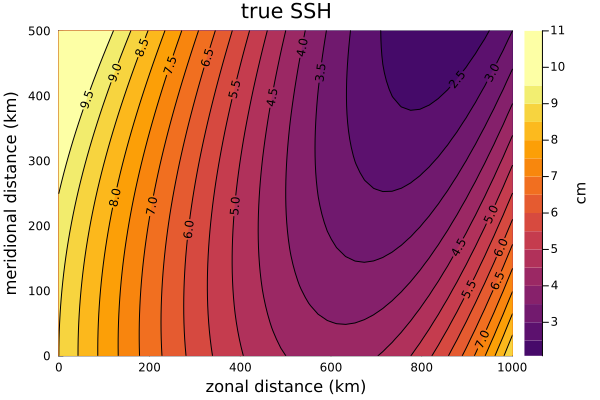

┌ Warning: GR: highest contour level less than maximal z value is not supported.
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/backends/gr.jl:577


In [189]:
contourf(rx, ry, ηtrue,xlabel="zonal distance",
    ylabel="meridional distance",clabels=true,title="true SSH",fill=true, levels = collect(0:0.5:10))


In [7]:
using Distributions
#determine random locations for synthetic observations
Nobs = Int(round(0.05 .* length(r))) # number of observations
robs = [(ΔX*rand(),ΔY*rand()) for i in 1:Nobs ] # uniformly sampled

# make E matrix for these observations, use bilinear interpolation
# get bilinear interpolation coefficients
E = zeros(Nobs,Nx*Ny)
for oo in eachindex(robs)
    coeffs = bilinear_interpolation_coefficients(robs[oo], rx, ry)
    E[oo,:] = vec(coeffs)
end

# how much observational noise
σₙ = 0.5cm
# get the noise covariance
Cnn = Diagonal(fill(σₙ^2,Nobs))
# Sample the true field
yvals = E*vec(ηtrue') + (1cm * rand(Normal(0, ustrip(σₙ)), Nobs))

100-element Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(cm,), 𝐋, nothing}}}:
  5.930388502997548 cm
  5.365242742018297 cm
  9.087964224244274 cm
  5.057498067177254 cm
  8.407706857206037 cm
  7.635729733982054 cm
  5.501309890481123 cm
 2.2755019188453587 cm
  5.500701461474492 cm
  6.609134488718564 cm
 3.8661180000464395 cm
 2.0597403230569755 cm
  3.635487111507416 cm
                     ⋮
 2.6658365084116524 cm
 2.3770083932189956 cm
  3.583573651841078 cm
  2.952008073162907 cm
  7.890060532753459 cm
 3.1180787417035343 cm
   4.52575733888355 cm
   9.57760048645316 cm
  2.894780465131559 cm
  3.885738745525856 cm
 5.2108682318818245 cm
 2.5960596966281444 cm

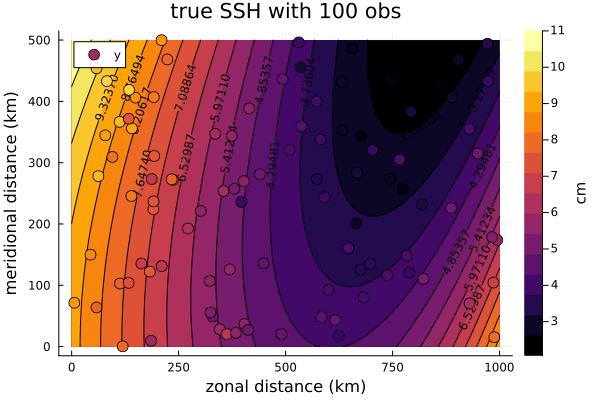

In [193]:
# add the observations to the plot
rxobs = [robs[oo][1] for oo in eachindex(robs)]

ryobs = [robs[oo][2] for oo in eachindex(robs)]

p = contourf(rx, ry, ηtrue,xlabel="zonal distance",
    ylabel="meridional distance",clabels=true,
    title="true SSH with $Nobs obs",fill=true, vmin = 0, vmax = 10)
scatter!(p, rxobs,ryobs,zcolor=yvals,label="y",cbar=true,markersize=6, vmin = 0, vmax = 10)


In [49]:
function construct_correlation_matrix(r, Lx, Ly)
    DX = [r[i][1]-r[j][1] for j in eachindex(r), i in eachindex(r)] # doesn't take advantage of symmetry
    DY = [r[i][2]-r[j][2] for j in eachindex(r), i in eachindex(r)] # doesn't take advantage of symmetry
    Rρ = exp.( (-(DX./Lx).^2) .- ((DY./Ly).^2))
    return Rρ
    # Rρ = Rρ + 1e-6I
end

construct_correlation_matrix (generic function with 1 method)

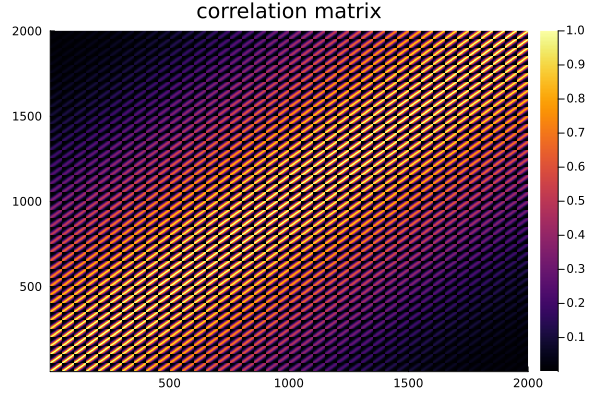

In [10]:
# set decorrelation lengthscales
Lx = 300km; Ly = 250km;
Rρ = construct_correlation_matrix(r, Lx, Ly)
heatmap(Rρ, title = "correlation matrix") # not simply monotonic

In [11]:
σ² = (10cm)^2
Lx = 300km; Ly = 250km;
Rρ = construct_correlation_matrix(r, Lx, Ly)
Cxx = σ² .* Rρ
y = Estimate(yvals,Cnn)

nx̃ = length(r)
x0vals = zeros(eltype(ηtrue[1]),nx̃) # first guess
x0 = Estimate(x0vals, Cxx)

x̃ = combine(x0, y, E)
x̃field = reshape(x̃.v,Nx,Ny); # turn it back into 2D

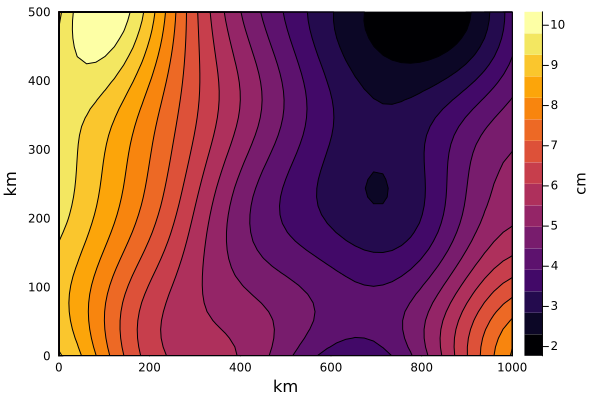

In [12]:
contourf(rx, ry, x̃field', vmin = 0, vmax = 10)

In [13]:
σ² = (10cm)^2
Lx = 300km; Ly = 250km;
Rρ = construct_correlation_matrix(r, Lx, Ly)
Cxx = σ² .* Rρ
y = Estimate(yvals,Cnn)

nx̃ = length(r)
x0vals = zeros(eltype(ηtrue[1]),nx̃) .+ mean(y.v) # first guess
x0 = Estimate(x0vals, Cxx)

x̃ = combine(x0, y, E)
x̃field = reshape(x̃.v,Nx,Ny); # turn it back into 2D

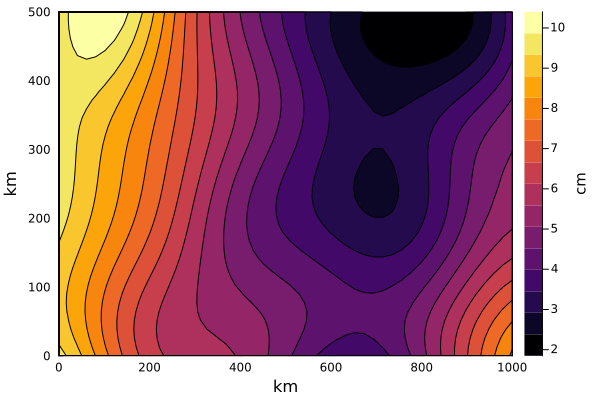

In [14]:
contourf(rx, ry, x̃field', vmin = 0, vmax = 10)

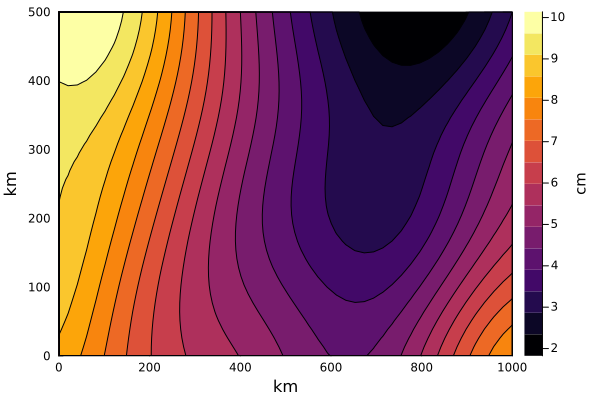

In [15]:
σ² = std(yvals)^2
Lx = 300km; Ly = 250km;
Rρ = construct_correlation_matrix(r, Lx, Ly)
Cxx = σ² .* Rρ
y = Estimate(yvals,Cnn)

nx̃ = length(r)
x0vals = zeros(eltype(ηtrue[1]),nx̃) .+ mean(y.v) # first guess
x0 = Estimate(x0vals, Cxx)

x̃ = combine(x0, y, E)
x̃field = reshape(x̃.v,Nx,Ny) # turn it back into 2D
contourf(rx, ry, x̃field', vmin = 0, vmax = 10)

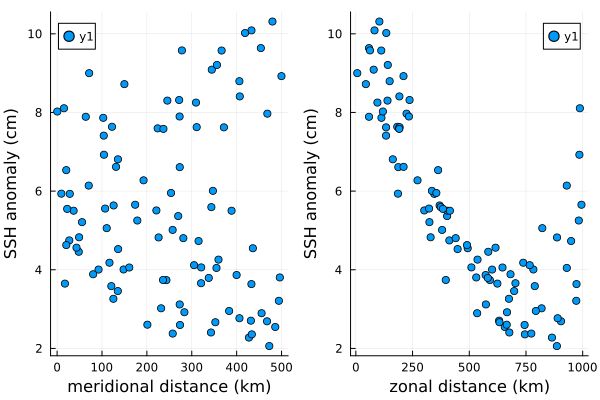

In [16]:
p1 = scatter(ryobs, y.v, xlabel = "meridional distance", ylabel = "SSH anomaly")
p2 = scatter(rxobs, y.v, xlabel = "zonal distance", ylabel = "SSH anomaly")
plot(p1, p2)

In [184]:
σ² = std(yvals)^2
Lx = 250km; Ly = 1000km;
Rρ = construct_correlation_matrix(r, Lx, Ly)
Cxx = σ² .* Rρ
y = Estimate(yvals,Cnn)

nx̃ = length(r)
x0vals = zeros(eltype(ηtrue[1]),nx̃) .+ mean(y.v) # first guess
x0 = Estimate(x0vals, Cxx)

x̃ = combine(x0, y, E)
x̃field = reshape(x̃.v,Nx,Ny) # turn it back into 2D
contourf(rx, ry, x̃field', vmin = 0, vmax = 10, levels = 0:1:10)

┌ Warning: GR: highest contour level less than maximal z value is not supported.
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/backends/gr.jl:577
┌ Warning: GR: highest contour level less than maximal z value is not supported.
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/backends/gr.jl:577
┌ Warning: GR: highest contour level less than maximal z value is not supported.
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/backends/gr.jl:577


In [124]:
function guass_markov_estimate2d_differentiable(yvals, r, Lx, Ly)
    Nobs = length(yvals)
    σₙ = 0.5 # how much observational noise
    Cnn = Diagonal(fill(σₙ^2,Nobs))    # get the noise covariance
    
    nx̃ = length(r)
    σ² = std(yvals)^2
    Rρ = construct_correlation_matrix(r, Lx, Ly)

    Cxx = σ² .* Rρ
    x0vals = zeros(eltype(yvals[1]),nx̃) 
    x0vals .+= mean(y.v) # first guess
    x0 = Estimate(x0vals, Cxx)

    x̃ = x0vals + Cxx *E' * inv(E*Cxx*E' + Cnn) * (yvals .- E*x0vals)
    
    return x̃
end

guass_markov_estimate2d_differentiable (generic function with 1 method)

In [125]:
function guass_markov_estimate2d(yvals, r, Lx, Ly)
    Nobs = length(yvals)
    σₙ = 0.5cm # how much observational noise
    Cnn = Diagonal(fill(σₙ^2,Nobs))    # get the noise covariance
    y = Estimate(yvals,Cnn)
    
    nx̃ = length(r)
    σ² = std(yvals)^2
    Rρ = construct_correlation_matrix(r, Lx, Ly)
    Cxx = σ² .* Rρ
    x0vals = zeros(eltype(yvals[1]),nx̃) 
    x0vals .+= mean(y.v) # first guess
    x0 = Estimate(x0vals, Cxx)
    return combine(x0, y, E)
end

guass_markov_estimate2d (generic function with 1 method)

In [136]:
ff(Lxx, Lyy) = guass_markov_estimate2d(yvals, r, Lxx * 1km, Lyy * 1km)
J(Lxx, Lyy) = ustrip(mean((reshape(ff(Lxx, Lyy).v,Nx,Ny)' .- ηtrue).^2))

J (generic function with 1 method)

10953.674743562602 cm
2.104078738144631 cm²


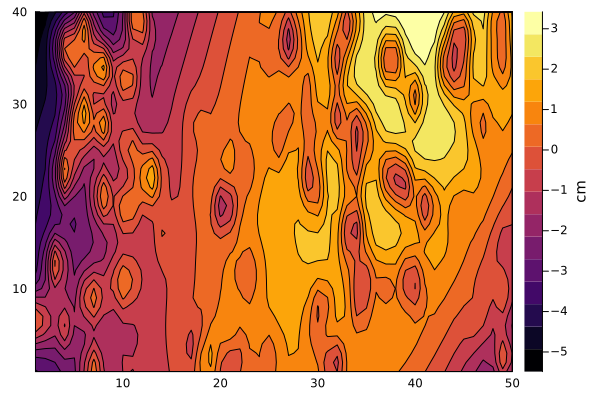

In [100]:
x̃ = guass_markov_estimate2d(yvals, r, 20km, 40km)
println(sum(x̃.v))
eps = reshape(x̃.v,Nx,Ny)' .- ηtrue
println(mean((eps.^2)))
contourf(eps, vmin = -5, vmax = 5)

0.0714305669014108 cm²


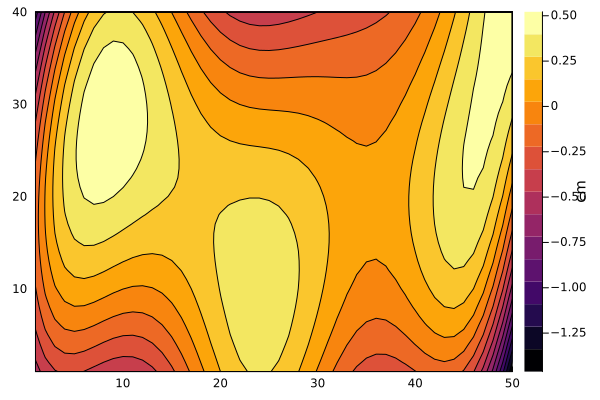

In [101]:
x̃ = guass_markov_estimate2d(yvals, r, 250km, 1000km)
eps = reshape(x̃.v,Nx,Ny)' .- ηtrue
println(mean((eps.^2)))
contourf(eps, vmin = -5, vmax = 5)

In [105]:
Lxsi = collect(10:200:ustrip(rx[end]))
Lysj = collect(10:200:ustrip(ry[end]))
Lxs, Lys = meshgrid(Lxsi, Lysj)
costlandscape = J.(Lxs, Lys)

3×5 Matrix{Quantity{Float64, 𝐋², Unitful.FreeUnits{(cm²,), 𝐋², nothing}}}:
  3.78428 cm²     1.1241 cm²    1.14793 cm²    1.52762 cm²    2.13389 cm²
  1.31164 cm²  0.0940688 cm²  0.0762511 cm²  0.0838031 cm²  0.0729712 cm²
 0.918553 cm²   0.067921 cm²  0.0555013 cm²  0.0636027 cm²  0.0595302 cm²

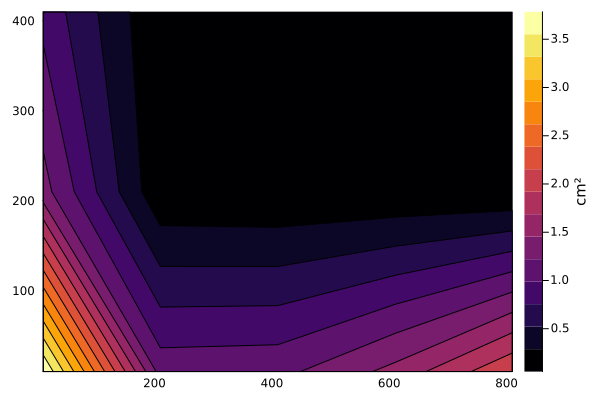

In [107]:
contourf(Lxsi, Lysj, costlandscape)

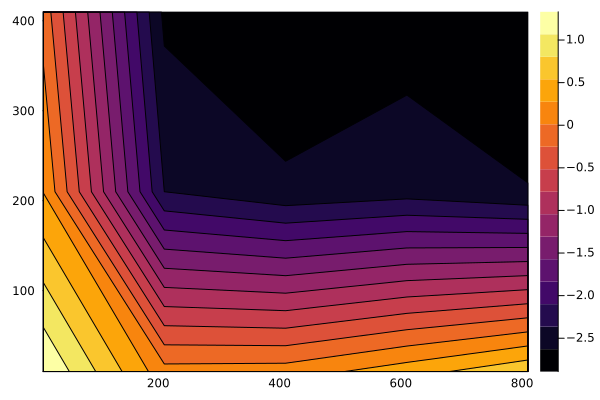

In [108]:
contourf(Lxsi, Lysj, log.(ustrip(costlandscape)))

In [167]:
using Optimization
using OptimizationBBO
using Zygote
lower = [10., 10.]
upper = [400., 900.]
initial_x = [350., 600.]
params = 0
obj = (x, p) -> J(x[1], x[2]) # Pass this function into OptimizationFunction

prob = OptimizationProblem(obj, initial_x, params, lb = lower, ub = upper)
sol = Optimization.solve(prob, BBO_adaptive_de_rand_1_bin_radiuslimited(), maxtime = 120)

retcode: MaxTime
u: 2-element Vector{Float64}:
 399.86134872955597
 526.2161851193657

In [168]:
sol.stats

SciMLBase.OptimizationStats
Number of iterations:                              61
Time in seconds:                                   121.648000
Number of function evaluations:                    112
Number of gradient evaluations:                    0
Number of hessian evaluations:                     0

In [178]:
using Optimization
using OptimizationBBO
using Zygote
lower = [10., 10.]
upper = [400., 1000.]
initial_x = [350., 600.]
params = 0
obj = (x, p) -> J(x[1], x[2]) # Pass this function into OptimizationFunction

prob = OptimizationProblem(obj, initial_x, params, lb = lower, ub = upper)
sol = Optimization.solve(prob, BBO_adaptive_de_rand_1_bin_radiuslimited(), maxtime = 550)

retcode: MaxTime
u: 2-element Vector{Float64}:
 399.94632466250965
 554.1745995311836

In [179]:
sol.stats

SciMLBase.OptimizationStats
Number of iterations:                              414
Time in seconds:                                   551.001495
Number of function evaluations:                    515
Number of gradient evaluations:                    0
Number of hessian evaluations:                     0

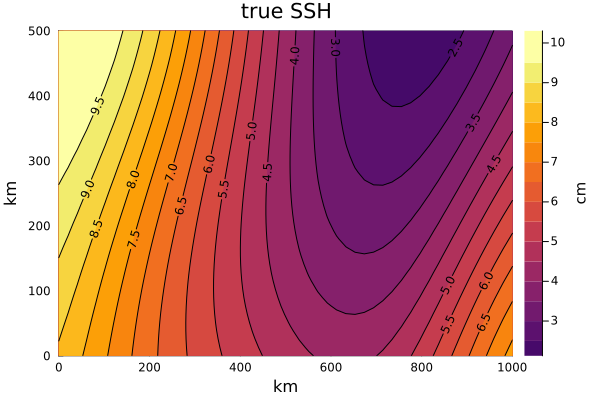

┌ Warning: GR: highest contour level less than maximal z value is not supported.
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/backends/gr.jl:577


In [194]:
σ² = std(yvals)^2
Lx = sol[1] * 1km; Ly = sol[2]km;
Rρ = construct_correlation_matrix(r, Lx, Ly)
Cxx = σ² .* Rρ
y = Estimate(yvals,Cnn)

nx̃ = length(r)
x0vals = zeros(eltype(ηtrue[1]),nx̃) .+ mean(y.v) # first guess
x0 = Estimate(x0vals, Cxx)

x̃ = combine(x0, y, E)
x̃field = reshape(x̃.v,Nx,Ny) # turn it back into 2D
contourf(rx, ry, x̃field', vmin = 0, vmax = 10,clabels=true,title="true SSH",fill=true, levels = collect(0:0.5:10))

0.05351959548807273 cm²


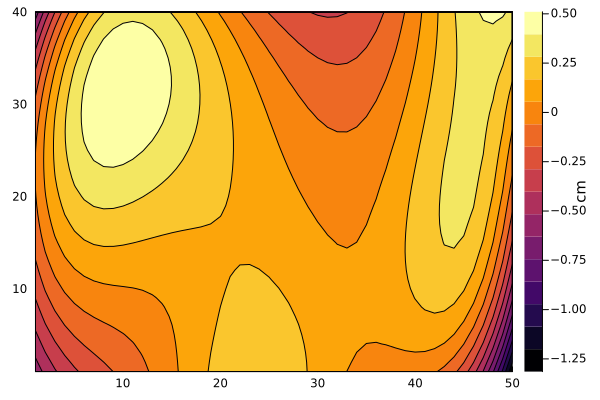

In [183]:
eps = reshape(x̃.v,Nx,Ny)' .- ηtrue
println(mean((eps.^2)))
contourf(eps, vmin = -5, vmax = 5)